### 0. Dependencies :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

### 1. Import data: (no test data as this is unsupervised learning)

In [2]:
train_data = pd.read_csv('./res/Physical_Activity_Monitoring_unlabeled.csv')

### 2. Clean, encode data:

#### 2.1 Visualize

/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_5513/2860196287.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=missing_percentage.index, x=missing_percentage.values, palette=bar_colors, orient = 'h')
/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_5513/2860196287.py:15: UserWarning: The palette list has more values (53) than needed (51), which may not be intended.
  sns.barplot(y=missing_percentage.index, x=missing_percentage.values, palette=bar_colors, orient = 'h')


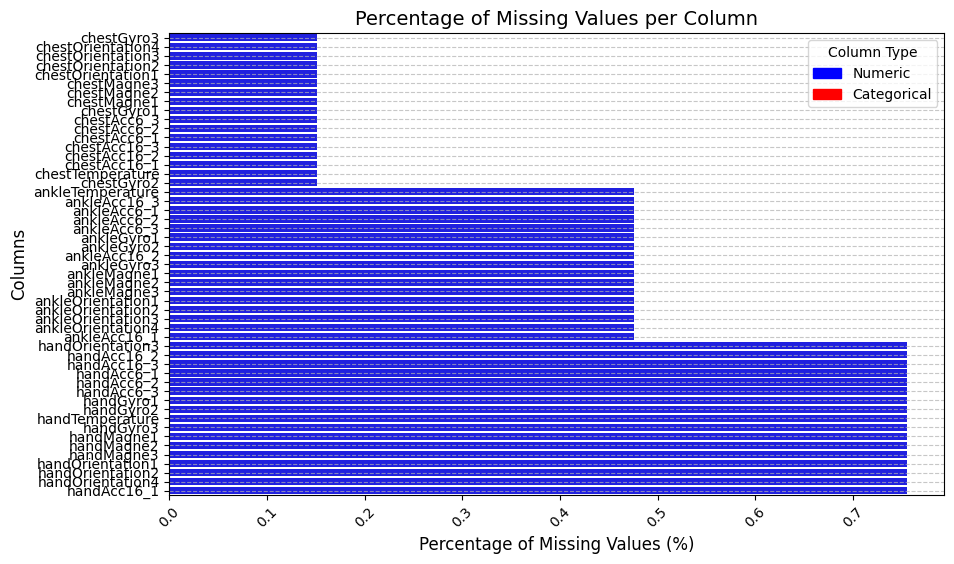

In [3]:
# Calculate the percentage of missing values per column
missing_percentage = train_data.isnull().mean().sort_values() * 100
missing_percentage = missing_percentage[missing_percentage>0]
# sub_train = train_data[[col for col in train_data.columns if col in missing_percentage.index]]

# Determine column types
column_types = train_data.dtypes.apply(lambda dtype: 'Numeric' if np.issubdtype(dtype, np.number) else 'Categorical')

# Assign colors based on column types
color_map = {'Numeric': 'blue', 'Categorical': 'red'}
bar_colors = [color_map[col_type] for col_type in column_types]

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(y=missing_percentage.index, x=missing_percentage.values, palette=bar_colors, orient = 'h')
plt.title("Percentage of Missing Values per Column", fontsize=14)
plt.xlabel("Percentage of Missing Values (%)", fontsize=12)
plt.ylabel("Columns", fontsize=12)
plt.xticks(rotation=45)
# plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in color_map.values()]
labels = list(color_map.keys())
plt.legend(handles, labels, title="Column Type")

plt.show()


#### Strategy : fill in missing values by Zeros
#### Then apply PCA
#### use the elbow method (and later the eigenval) method to determine how many dimensions will be used to cluster
#### cluster using KMeans or DBSCAN (it might a good idea to project the data on 2 or 3D and visualize which method might be more suited in 2/3D)

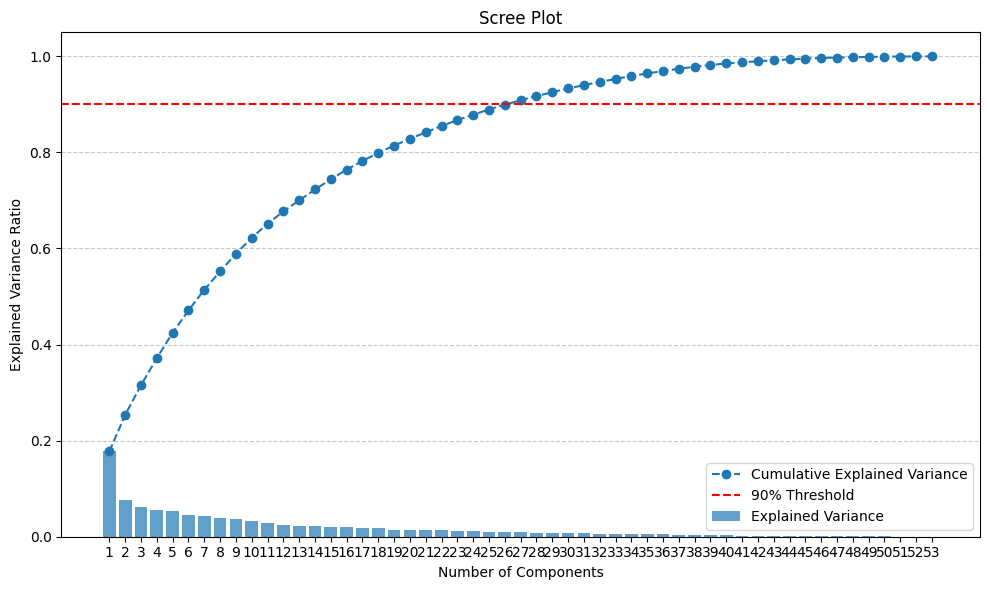

Optimal number of components to retain 80% variance: 19


In [19]:
# PCA

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Handle missing values using mean imputation
imputer = SimpleImputer(strategy='most_frequent')
train_data_imputed = imputer.fit_transform(train_data)

# Standardize the data (important for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_data_imputed)

# Apply PCA
pca = PCA()
pca.fit(scaled_data)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(explained_variance_ratio) + 1),
    np.cumsum(explained_variance_ratio),
    marker='o',
    linestyle='--',
    label="Cumulative Explained Variance",
)
plt.bar(
    range(1, len(explained_variance_ratio) + 1),
    explained_variance_ratio,
    alpha=0.7,
    label="Explained Variance",
)
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Threshold')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Suggest number of components for 90% explained variance
optimal_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.8) + 1
print(f"Optimal number of components to retain 80% variance: {optimal_components}")


In [20]:
# We will selecct optimal_components then

principal = PCA(n_components=optimal_components)
x = principal.fit_transform(scaled_data)

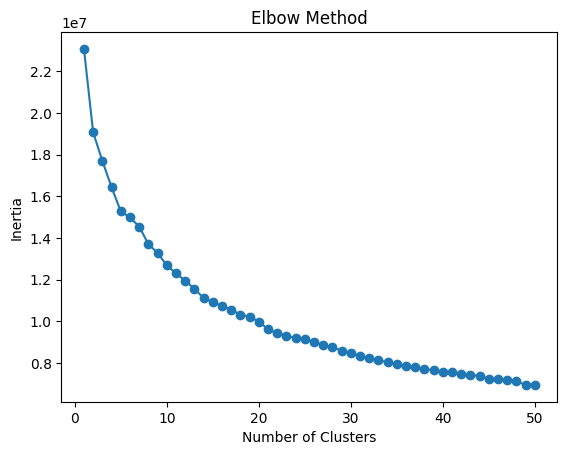

In [26]:
# We will perform silouhette analysis to determine the number of clusters to use in KMeans
import matplotlib.cm as cm

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, silhouette_samples

inertia = []
n_cluster_max = 50
for k in range(1, n_cluster_max+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x)  # X is your data
    inertia.append(kmeans.inertia_)

plt.plot(range(1, n_cluster_max+1), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()
plt.show()

In [59]:
# final decision:
n_cluster_final = 6

predict = KMeans(n_clusters=n_cluster_final, random_state=42).fit_predict(x)

output = pd.DataFrame(data={'activityID': predict} )
output.index.name = 'Index'
d = {int(k): int(v) for k, v in zip(output['activityID'].unique(), np.arange(1,len(predict)+1))}
output.loc[:, ['activityID']] = output['activityID'].apply(lambda x: d[x])
output.to_csv('./out/submission.csv')


/var/folders/54/l3922hpj5_9ct1rg7_8w8d080000gn/T/ipykernel_5513/3929839656.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 2 3 ... 3 4 2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  output.loc[:, ['activityID']] = output['activityID'].apply(lambda x: d[x])
